## QBO PAKAI GRU 90:10

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import plotly
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

In [2]:
# Path file
file_qbo = "QBO Index.xlsx"

# Membaca file Excel
df_qbo = pd.read_excel(file_qbo)

# Menampilkan beberapa baris pertama dari masing-masing dataset
df_qbo.head()

,Unnamed: 0,Jan,Feb,Mar,Apr,Mei,Jun,Jul,Ags,Sep,Okt,Nov,Des
0,1948,-4.44,-5.78,-7.31,-6.70,-5.57,-4.73,-5.51,-7.22,-7.24,-6.07,-6.28,-8.18
1,1949,-9.77,-11.80,-11.72,-10.69,-9.34,-9.43,-9.07,-9.08,-8.32,-7.01,-6.43,-7.24
2,1950,-8.99,-11.37,-10.63,-8.19,-6.09,-6.61,-7.11,-6.51,-3.82,-2.39,-2.18,-3.31
3,1951,-6.01,-5.32,-1.93,0.91,2.26,-0.30,-2.70,-5.31,-5.92,-4.59,-3.65,-3.98
4,1952,-6.80,-7.71,-6.99,-5.68,-4.76,-6.00,-7.60,-8.15,-5.73,-2.96,-0.51,-1.65


In [3]:
# Reshape the data into a time-series format
df_melted = df_qbo.melt(id_vars=["Unnamed: 0"], var_name="Month", value_name="QBO")

# Rename columns for clarity
df_melted.rename(columns={"Unnamed: 0": "Year"}, inplace=True)

# Convert Year and Month into a datetime format
month_dict = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "Mei": 5, "Jun": 6,
    "Jul": 7, "Ags": 8, "Sep": 9, "Okt": 10, "Nov": 11, "Des": 12
}
df_melted["Month"] = df_melted["Month"].map(month_dict)
df_melted["Date"] = pd.to_datetime(df_melted[["Year", "Month"]].assign(day=1))

# Sort by date
df_melted = df_melted.sort_values(by="Date")

# Drop unnecessary columns
df_melted = df_melted[["Date", "QBO"]]

# Display the first few rows of the transformed data
df_melted.head()

,Date,QBO
0,1948-01-01,-4.44
77,1948-02-01,-5.78
154,1948-03-01,-7.31
231,1948-04-01,-6.70
308,1948-05-01,-5.57


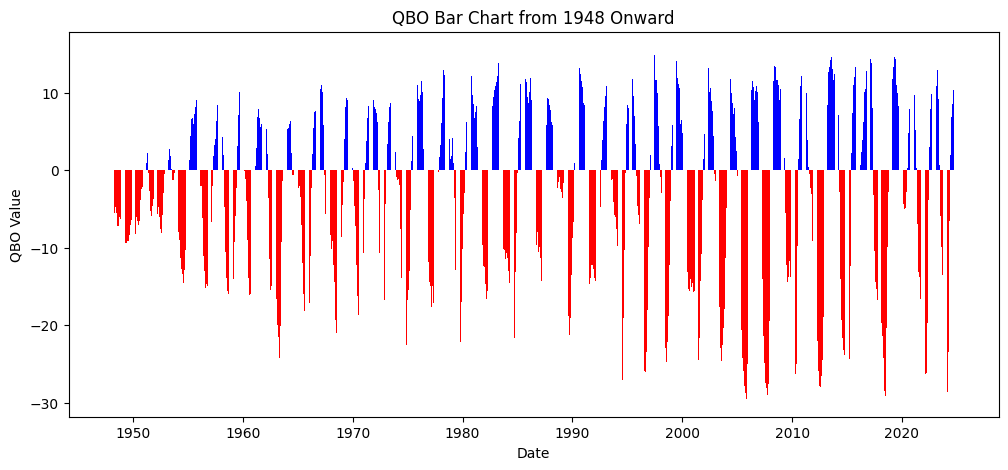

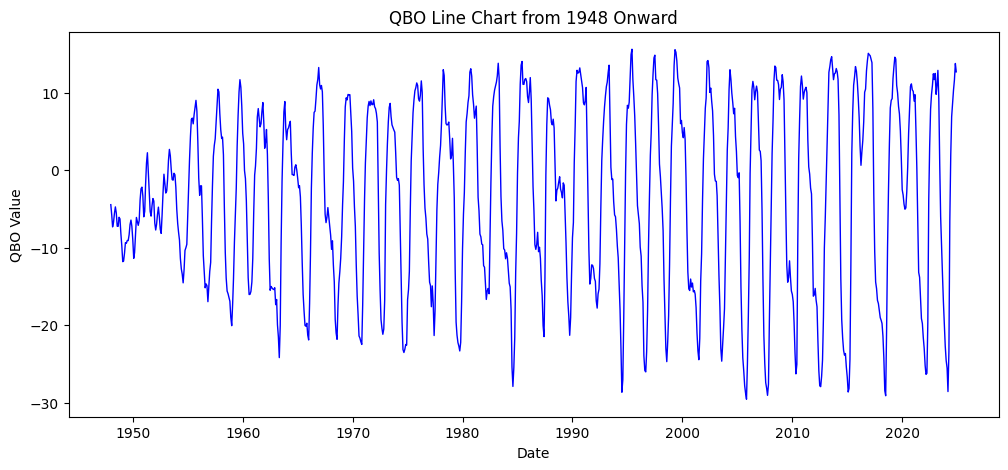

In [4]:
# Plot bar chart
plt.figure(figsize=(12, 5))
colors = ['blue' if val > 0 else 'red' for val in df_melted["QBO"]]
plt.bar(df_melted["Date"], df_melted["QBO"], color=colors, width=20)
plt.xlabel("Date")
plt.ylabel("QBO Value")
plt.title("QBO Bar Chart from 1948 Onward")
plt.show()

# Plot line chart
plt.figure(figsize=(12, 5))
plt.plot(df_melted["Date"], df_melted["QBO"], color="blue", linewidth=1)
plt.xlabel("Date")
plt.ylabel("QBO Value")
plt.title("QBO Line Chart from 1948 Onward")
plt.show()

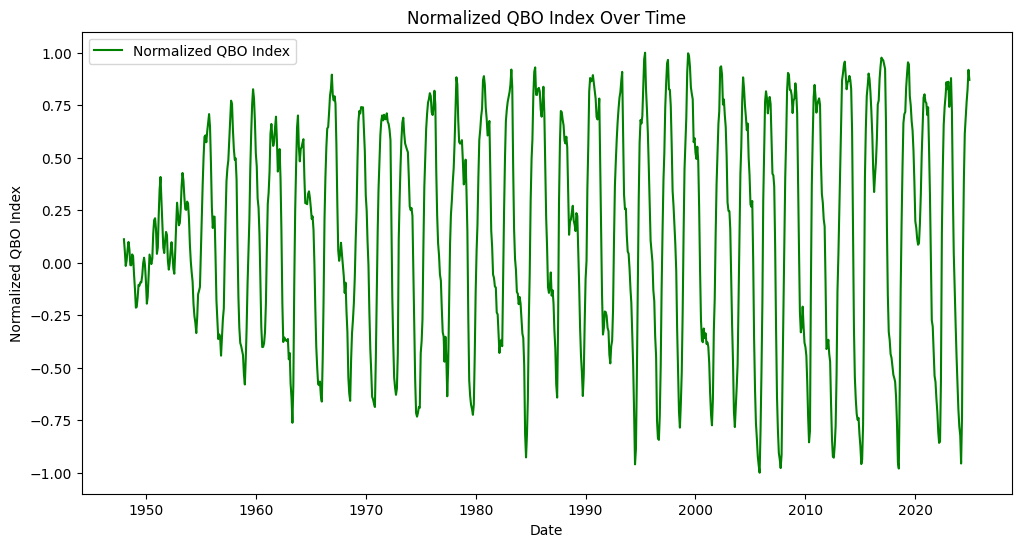

In [5]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(-1, 1))
df_melted["QBO_Index_Scaled"] = scaler.fit_transform(df_melted[["QBO"]])

# Plot normalized data
plt.figure(figsize=(12, 6))
plt.plot(df_melted["Date"], df_melted["QBO_Index_Scaled"], label="Normalized QBO Index", color='green')
plt.title("Normalized QBO Index Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized QBO Index")
plt.legend()
plt.show()

In [6]:
# Membagi data menjadi train dan test set (misalnya 90% train, 10% test)
train_size = int(len(df_melted) * 0.9)
train_data = df_melted.iloc[:train_size]
test_data = df_melted.iloc[train_size:]

# Menampilkan ukuran dataset train dan test
train_data.shape, test_data.shape

((831, 3), (93, 3))

In [7]:
# Fungsi untuk membuat sequences
def create_sequences(data, seq_length=12):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

# Menyiapkan data dalam bentuk array
seq_length = 12  # Panjang sequence (misalnya, 12 bulan)
train_sequences, train_labels = create_sequences(train_data["QBO_Index_Scaled"].values, seq_length)
test_sequences, test_labels = create_sequences(test_data["QBO_Index_Scaled"].values, seq_length)

# Reshape untuk kompatibilitas dengan GRU (samples, timesteps, features)
train_sequences = train_sequences.reshape(-1, seq_length, 1)
test_sequences = test_sequences.reshape(-1, seq_length, 1)

# Menampilkan bentuk akhir data
train_sequences.shape, train_labels.shape, test_sequences.shape, test_labels.shape


((819, 12, 1), (819,), (81, 12, 1), (81,))

In [8]:
# Membangun model GRU
model = Sequential([
    GRU(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1)  # Output layer
])

# Kompilasi model
model.compile(optimizer="adam", loss="mse")

# Menampilkan ringkasan model
model.summary()

# Train model
model.fit(train_sequences, train_labels, epochs=50, batch_size=16, validation_data=(test_sequences, test_labels))

# Evaluate model
loss = model.evaluate(test_sequences, test_labels)
print(f"Test Loss: {loss}")

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.2002 - val_loss: 0.0529
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0339 - val_loss: 0.0340
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0285 - val_loss: 0.0282
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0216 - val_loss: 0.0242
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0240 - val_loss: 0.0234
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0211 - val_loss: 0.0189
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0211 - val_loss: 0.0176
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0154 - val_loss: 0.0176
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0164 - val_loss: 0.0155
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0167 - val_loss: 0.0176
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.

In [9]:
# Nowcasting (Predicting current value based on past data)
nowcast_input = train_sequences[-1].reshape(1, seq_length, 1)
nowcast_prediction = model.predict(nowcast_input)
print(f"Nowcasting Prediction: {scaler.inverse_transform(nowcast_prediction.reshape(-1, 1))}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
Nowcasting Prediction: [[12.2358885]]


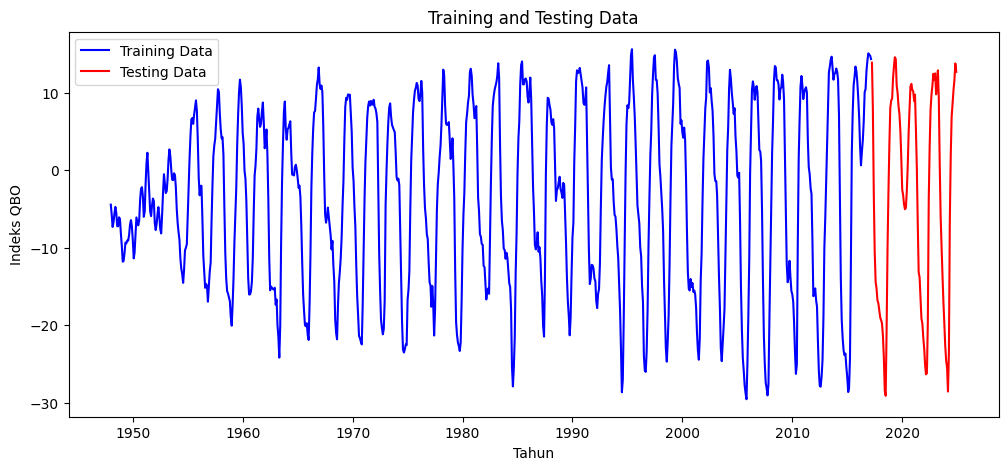

Data Training (Garis Biru):
          Date    QBO
0   1948-01-01  -4.44
77  1948-02-01  -5.78
154 1948-03-01  -7.31
231 1948-04-01  -6.70
308 1948-05-01  -5.57
..         ...    ...
838 2016-11-01  14.16
915 2016-12-01  15.09
69  2017-01-01  14.92
146 2017-02-01  14.78
223 2017-03-01  14.35

[831 rows x 2 columns]

Data Testing (Garis Merah):
          Date    QBO
300 2017-04-01  13.88
377 2017-05-01   8.01
454 2017-06-01  -3.18
531 2017-07-01 -10.48
608 2017-08-01 -14.42
..         ...    ...
615 2024-08-01   8.61
692 2024-09-01  10.36
769 2024-10-01  11.64
846 2024-11-01  13.78
923 2024-12-01  12.70

[93 rows x 2 columns]


In [10]:
# Plot training and testing data together
plt.figure(figsize=(12, 5))
plt.plot(train_data["Date"], train_data["QBO"], label="Training Data", color='blue')
plt.plot(test_data["Date"], test_data["QBO"], label="Testing Data", color='red')
plt.xlabel("Tahun")
plt.ylabel("Indeks QBO")
plt.legend()
plt.title("Training and Testing Data")
plt.show()

# Menampilkan data training (garis biru)
print("Data Training (Garis Biru):")
print(train_data[["Date", "QBO"]])

# Menampilkan data testing (garis merah)
print("\nData Testing (Garis Merah):")
print(test_data[["Date", "QBO"]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Forecasted Values: [[13.657828  ]
 [12.439031  ]
 [11.037225  ]
 [ 9.837901  ]
 [ 8.603517  ]
 [ 7.1298656 ]
 [ 5.5572243 ]
 [ 3.8274755 ]
 [ 1.8681049 ]
 [-0.31373313]
 [-2.472613  ]
 [-4.6572013 ]]


C:\Users\HP\AppData\Local\Temp\ipykernel_23184\513560717.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date, periods=13, freq='M')[1:]


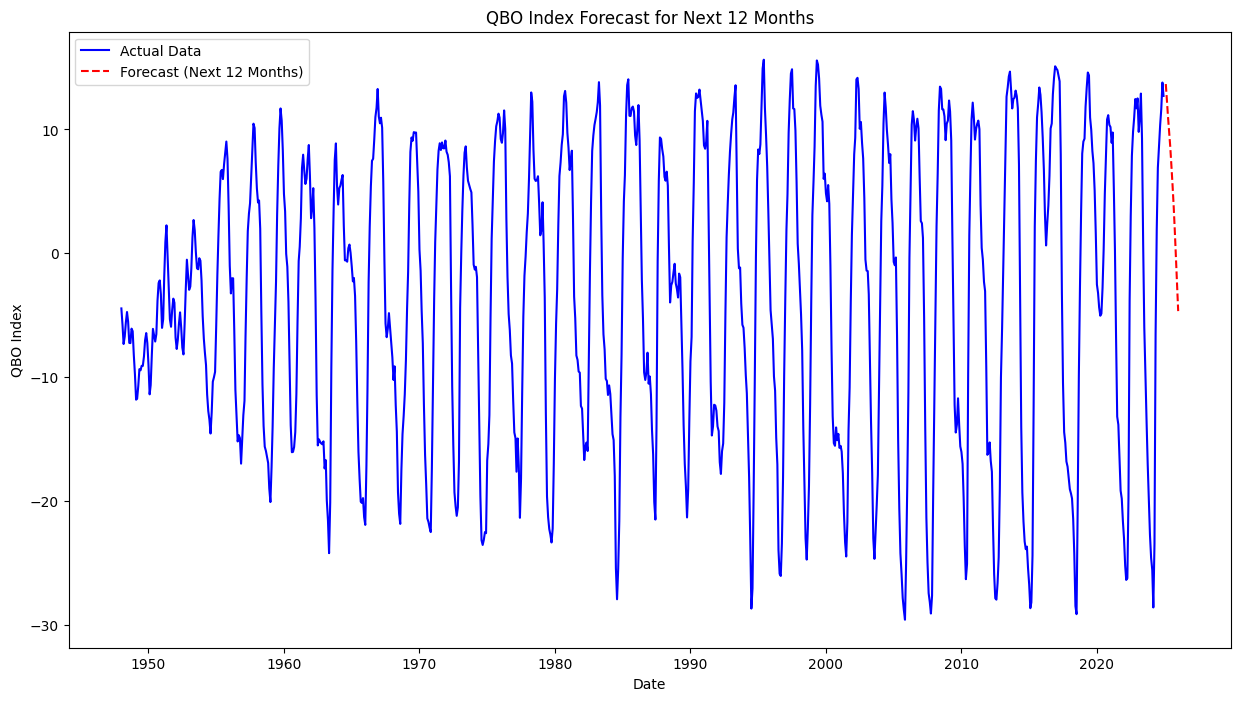

In [11]:
# Forecasting (Predicting future values iteratively)
def forecast(model, start_sequence, steps=12):
    forecasted = []
    current_seq = start_sequence.copy()
    for _ in range(steps):
        prediction = model.predict(current_seq.reshape(1, seq_length, 1))
        forecasted.append(prediction[0, 0])
        current_seq = np.roll(current_seq, -1)
        current_seq[-1] = prediction[0, 0]
    return scaler.inverse_transform(np.array(forecasted).reshape(-1, 1))

# Generate forecast for next 12 months
forecast_values = forecast(model, test_sequences[-1])
print(f"Forecasted Values: {forecast_values}")

# Generate future dates for forecasting
last_date = df_melted["Date"].iloc[-1]
future_dates = pd.date_range(last_date, periods=13, freq='M')[1:]

# Plot Forecasting Results
plt.figure(figsize=(15, 8))
plt.plot(df_melted["Date"], df_melted["QBO"], label="Actual Data", color='blue')
plt.plot(future_dates, forecast_values, label="Forecast (Next 12 Months)", color='red', linestyle='dashed')
plt.title("QBO Index Forecast for Next 12 Months")
plt.xlabel("Date")
plt.ylabel("QBO Index")
plt.legend()
plt.show()


In [12]:
# Compute R^2 score
y_true = scaler.inverse_transform(test_labels.reshape(-1, 1))
y_pred = scaler.inverse_transform(model.predict(test_sequences).reshape(-1, 1))
r2 = r2_score(y_true, y_pred)# Compute metrics for training and testing
y_train_true = scaler.inverse_transform(train_labels.reshape(-1, 1))
y_train_pred = scaler.inverse_transform(model.predict(train_sequences).reshape(-1, 1))
y_test_true = scaler.inverse_transform(test_labels.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(model.predict(test_sequences).reshape(-1, 1))

r2_train = r2_score(y_train_true, y_train_pred)
mae_train = mean_absolute_error(y_train_true, y_train_pred)
mse_train = mean_squared_error(y_train_true, y_train_pred)
rmse_train = np.sqrt(mse_train)

r2_test = r2_score(y_test_true, y_test_pred)
mae_test = mean_absolute_error(y_test_true, y_test_pred)
mse_test = mean_squared_error(y_test_true, y_test_pred)
rmse_test = np.sqrt(mse_test)

print(f"R^2 Score (Training): {r2_train}")
print(f"MAE (Training): {mae_train}")
print(f"MSE (Training): {mse_train}")
print(f"RMSE (Training): {rmse_train}")

print(f"R^2 Score (Testing): {r2_test}")
print(f"MAE (Testing): {mae_test}")
print(f"MSE (Testing): {mse_test}")
print(f"RMSE (Testing): {rmse_test}")
print(f"R^2 Score: {r2}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step  
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
R^2 Score (Training): 0.9702952230471784
MAE (Training): 1.5179257599737437
MSE (Training): 4.05265261173246
RMSE (Training): 2.0131201185553884
R^2 Score (Testing): 0.9687256077774999
MAE (Testing): 1.840238557038484
MSE (Testing): 6.112372622250316
RMSE (Testing): 2.4723213023897834
R^2 Score: 0.9687256077774999


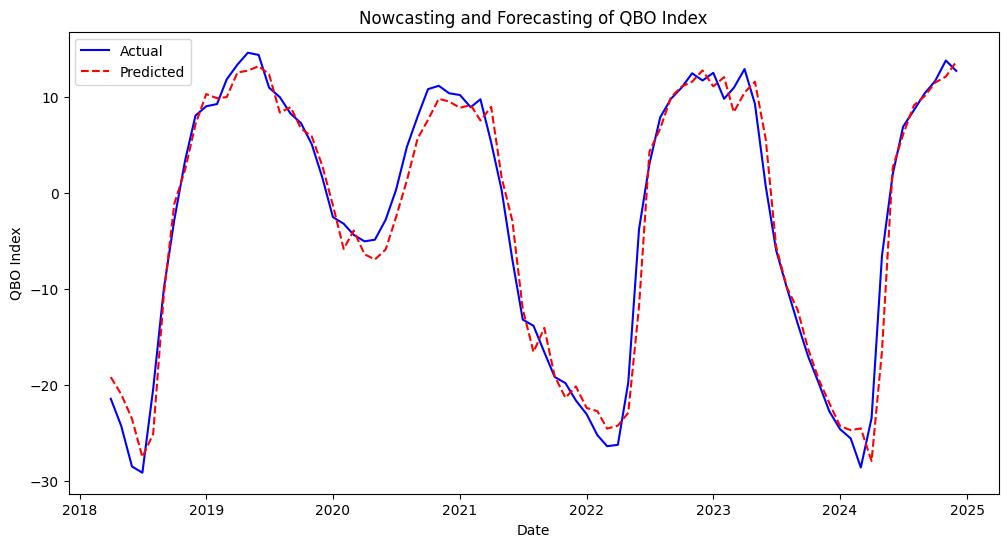

In [13]:
# Plot Nowcasting and Forecasting Results
plt.figure(figsize=(12, 6))
plt.plot(df_melted["Date"].iloc[-len(test_labels):], y_true, label="Actual", color='blue')
plt.plot(df_melted["Date"].iloc[-len(test_labels):], y_pred, label="Predicted", color='red', linestyle='dashed')
plt.title("Nowcasting and Forecasting of QBO Index")
plt.xlabel("Date")
plt.ylabel("QBO Index")
plt.legend()
plt.show()